# Neural Networks - Deep Learning 
## Project 1)


Ονοματεπώνυμο: Κωνσταντίνος - Ηλιας Χονδρορρίζος

In [3]:
#Importing the libraries i'm going to use
import gzip
import pickle
import time


import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
sns.set_theme(palette = "Spectral")


from sklearn.model_selection import StratifiedKFold,GridSearchCV
from sklearn.manifold import TSNE 
from sklearn.metrics import accuracy_score,classification_report,balanced_accuracy_score,average_precision_score,f1_score,confusion_matrix
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid 
from sklearn.decomposition import PCA


import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation ,Flatten, Conv2D, MaxPooling2D ,Dropout
from keras.optimizers import Adam ,SGD
from keras.regularizers import l1
from scikeras.wrappers import KerasClassifier

# Intermediate Part

In [4]:
'''
parameters:
@file : the path where the file exists into the computer.
    Loading the data structures from the binary file.
    
return:
@dict: a dictionary with the data and the labels of each batch. 
'''
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        
    return dict

In [5]:
#load all bathches into a list.
dataBatchs = (unpickle(r'.\\cifar-10-batches-py\\data_batch_1')[b'data'],
                unpickle(r'.\\cifar-10-batches-py\data_batch_2')[b'data'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_3')[b'data'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_4')[b'data'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_5')[b'data'])
 
labels_train = (unpickle(r'.\\cifar-10-batches-py\\data_batch_1')[b'labels'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_2')[b'labels'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_3')[b'labels'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_4')[b'labels'],
                unpickle(r'.\\cifar-10-batches-py\\data_batch_5')[b'labels'])

testBatch = unpickle(r'.\\cifar-10-batches-py\\test_batch')

#concatenate the batches and flip the tuples to numpy arrays.
dataBatch = np.concatenate(dataBatchs,axis=0)
labelsBatch = np.concatenate(labels_train,axis=0)[:2000]

In [6]:
scale_mapper = {0 : 'airplane' ,1 : 'automobile' ,2 : 'bird',
                3 : 'cat', 4 : 'deer',5 : 'dog',6 : 'frog' ,7 : 'horse' ,8 : 'ship' ,9 : 'truck'}

label: ship


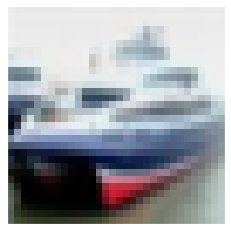

In [7]:
#lets have a quick look of the actual data

'''
parameters:
@img : image data.
@lb :label of img element.
    Displays the data of a sample as an image and the label of it(as a number 0-9)
'''
def Plot_Cifar_Image(img,lb=""):
    image = img.reshape(3,32,32) 
    image = image.transpose(1,2,0)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    print("label:",scale_mapper[lb])
    
Plot_Cifar_Image(testBatch[b'data'][1],testBatch[b'labels'][1])
    

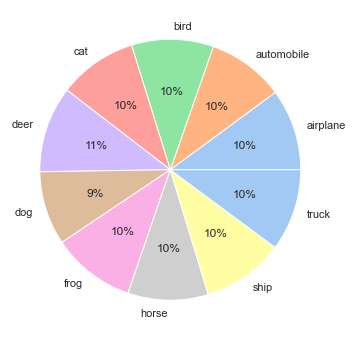

In [8]:
#also lets check the distribution of the train data with a pie chart.
data_dist = [np.count_nonzero(labelsBatch == 0) ,np.count_nonzero(labelsBatch == 1) ,np.count_nonzero(labelsBatch == 2) ,
      np.count_nonzero(labelsBatch == 3) ,np.count_nonzero(labelsBatch == 4) ,np.count_nonzero(labelsBatch == 5) ,
      np.count_nonzero(labelsBatch == 6) ,np.count_nonzero(labelsBatch == 7) ,np.count_nonzero(labelsBatch == 8) ,
      np.count_nonzero(labelsBatch == 9)]


fig = plt.figure(figsize=(10, 6))
plt.pie(data_dist, labels= list(scale_mapper.values()), 
        colors=sns.color_palette('pastel')[0:9], autopct='%.0f%%')
plt.show()
#and as we can see the size of the all classes are equaly scattered in the set.

In [9]:
images_train = dataBatch[:2000].astype("float32") / 255.0
labels_train = keras.utils.to_categorical(labelsBatch[:2000], num_classes=10)

images_test = testBatch[b'data'][:500].astype("float32") /255.0
labels_test = keras.utils.to_categorical(testBatch[b'labels'][:500], num_classes=10)

### K - Nearest Neighbors Algorithm

In [10]:
'''
parameters:
@f: the decorated function
    A decorator function that calculates the running time of another given function.

return:
@result: the result of the wrapped function
@full_time: the time it took the f function to run in seconds.
'''
def timing(f):
    def wrapper(*args,**kwargs):
        start = time.time()
        result = f(*args,**kwargs)
        end = time.time()
        full_time = float(end-start)
        return result , full_time
    return wrapper

In [11]:
'''
parameters:
@neighbors: number of nearest neighbors.
    Function that initializes, runs and predicts the labels of the whole traing set using the knn algorithm.

return:
The predicted labels of the test dataset and the runnig time of the function.
'''
@timing
def knn(neighbors):
    knn = KNeighborsClassifier(n_neighbors = neighbors,weights = 'distance',n_jobs = -1)
    knn.fit(images_train,labels_train)

    return knn.predict(images_test)

In [12]:
#calling the classifiers and saving their stats into accuracy_and_time array
accuracy_and_time = np.empty([0,2])

pred ,total_time = knn(1)
accuracy = float(accuracy_score(labels_test,pred)*100)

accuracy_and_time = np.vstack((accuracy_and_time,[accuracy,total_time]))


pred ,total_time = knn(3)
accuracy = accuracy_score(labels_test,pred)*100

accuracy_and_time = np.vstack((accuracy_and_time,[accuracy,total_time]))

### Nearest Centroid Algorithm

In [13]:
'''
    Function that initializes, runs and predicts the labels of the whole traing set using the nearest centroid algorithm.

return:
The predicted labels of the test dataset and the runnig time of the function.
'''
@timing
def Nearest_Centroid():
    nc = NearestCentroid()
    nc.fit(images_train,labelsBatch)
    
    return nc.predict(images_test)

In [14]:
#same thing for the nearest centroid but the labels are not one hot encoded.
pred ,total_time = Nearest_Centroid()
accuracy = accuracy_score(testBatch[b'labels'][:500],pred)*100

accuracy_and_time=np.vstack((accuracy_and_time , [accuracy,total_time]))

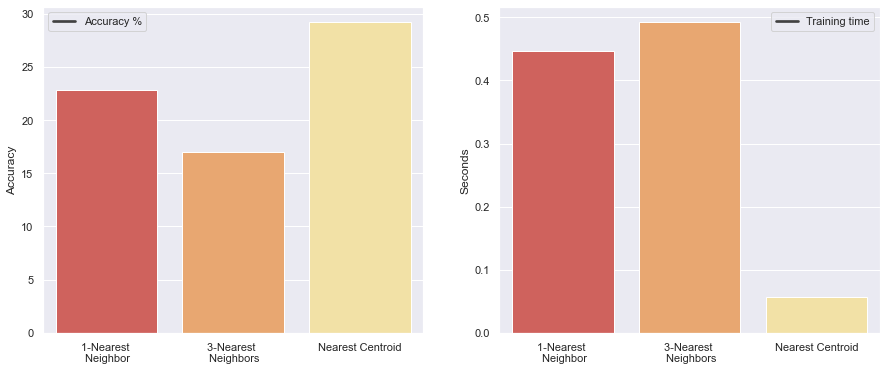

In [15]:
#making two bar-plots, one for the accuracy and one for the training time
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,6))

sns.barplot(ax=axes[0],data = {"x" : ["1-Nearest \n Neighbor","3-Nearest \n Neighbors","Nearest Centroid"] ,
                               "y" : accuracy_and_time[:,0]  } ,x = "x" , y = "y")
axes[0].set_ylabel("Accuracy")
axes[0].legend(["Accuracy %"])


sns.barplot(ax =axes[1] ,data = {"x" : ["1-Nearest \n Neighbor","3-Nearest \n Neighbors","Nearest Centroid"] ,
                                 "y" : accuracy_and_time[:,1] } ,x = "x" , y = "y")
axes[1].set_ylabel("Seconds")
axes[1].legend(["Training time"])

plt.show()

# Main project

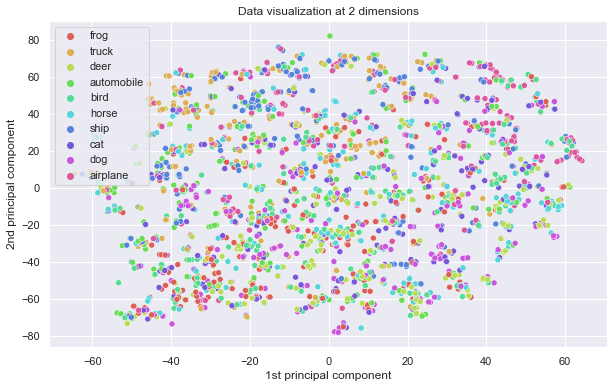

In [14]:
X_embedded_at2 = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(images_train)

ax = plt.figure(figsize=(10,6))
sns.scatterplot(x = X_embedded_at2[:,0] ,y = X_embedded_at2[:,1] , hue = [scale_mapper[i] for i in labelsBatch[:2000]],
                ci=None ,palette=sns.color_palette("hls", 10))

plt.title('Data visualization at 2 dimensions')
plt.xlabel('1st principal component')
plt.ylabel('2nd principal component')

plt.show()

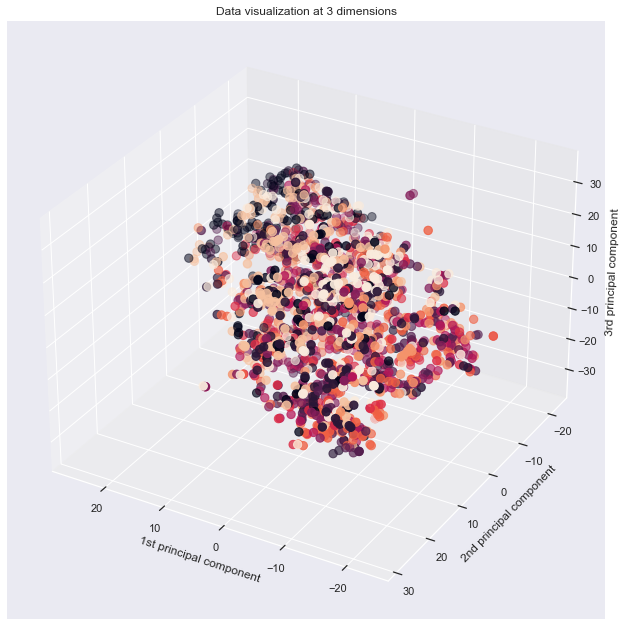

In [15]:
X_embedded_at3 = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3).fit_transform(images_train)

fig = plt.figure(figsize=(12, 11))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_embedded_at3[:,0] ,X_embedded_at3[:,1] ,X_embedded_at3[:,2]  , 
            c = labelsBatch[:2000] , s=70)

ax.set_title('Data visualization at 3 dimensions')
ax.set_xlabel('1st principal component')
ax.set_ylabel('2nd principal component')
ax.set_zlabel('3rd principal component')

ax.view_init(30, 120)
plt.show()

In [27]:
class NetworkModel:
    
    def __init__(self,btch_size,n_of_epochs):
        
        self.batch = btch_size
        self.eps = n_of_epochs 
    '''
    parameters:
    @layers: a list of layers.
        Function that creates the structure of the neural network and returns it.

    return:
    The ready to use model.
    
    '''
    def Create_model(self,layers):
        
        self.model = Sequential()
    
        for layer in layers:
            self.model.add(layer)        
        self.model.add(Dense(10, activation='softmax'))
        self.model.compile(loss='categorical_crossentropy', optimizer = "adam" , metrics=['accuracy'])
        return self.model
    
    '''
    parameters:
    @layers: a list of layers.
        Function that creates the structure of the neural network and returns it.

    return:
    The ready to use model.
    
    '''
    @timing
    def Fit_model(self,model,X_train,y_train,X_test,y_test):
        
        results = model.fit(X_train,y_train, epochs = self.eps, batch_size= self.batch, verbose=0, 
                            validation_data=(X_test,y_test))
        
        return results
    
    @staticmethod
    def Evaluate_model(model,images_test,labels_test):
        
        y_pred = model.predict(images_test)
        
        y_pred = convert(y_pred)
        
        metric1 = accuracy_score(labels_test,y_pred)
        metric2 = f1_score(labels_test,y_pred,average='micro')
        
        print("Metrics:")
        print("Accuracy: {}\nF1 score(micro): {}".format(metric1,metric2))
        
        print("Confusion Matrix:")             
        conf_matrix =  confusion_matrix(labels_test, y_pred)       
        ax= plt.subplot()
        sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax);
        ax.xaxis.set_ticklabels(scale_mapper.values())[::-1]; ax.yaxis.set_ticklabels(list(scale_mapper.values()))
        plt.xticks(rotation=45)
        plt.yticks(rotation=45)
        plt.show()
        

In [17]:
def convert(List):
    
    array = np.asarray([])
    for i in List:
        Max = i.max()
        index = 0
        for j in i:
            if Max == j :
                array = np.append(array,index)
                break

            index+=1
    
    return array
        

### MLP

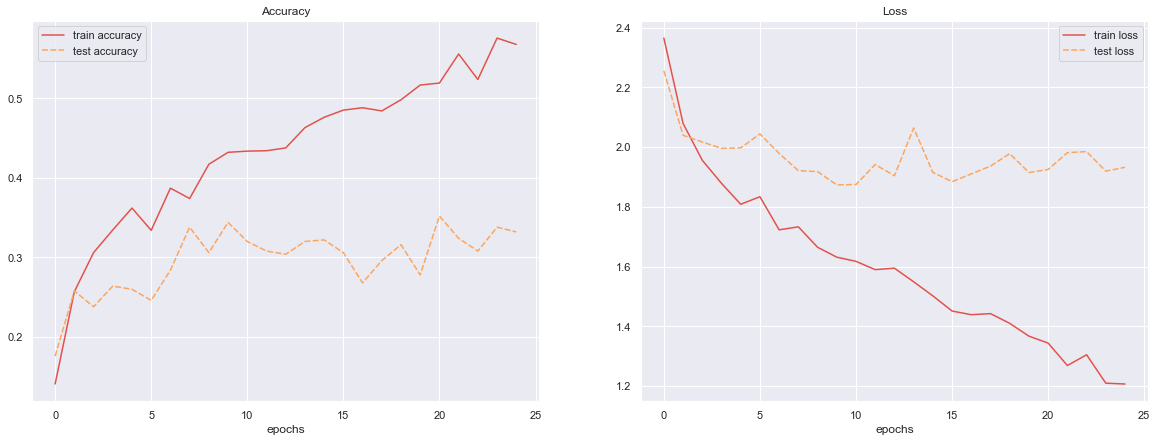

In [18]:
MLP = [Dense(256, activation = "relu", input_dim=3072, kernel_initializer='random_uniform'),
       Dense(128, activation='relu')]


net = NetworkModel(50,25)
model = net.Create_model(MLP)


stats , training_time =  net.Fit_model(model,images_train,labels_train,images_test,labels_test)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(20,7))

sns.lineplot(ax = axes[0] ,data= [stats.history['accuracy'],stats.history['val_accuracy']])
axes[0].legend(['train accuracy', 'test accuracy'])
axes[0].set_title("Accuracy")
axes[0].set_xlabel("epochs")


sns.lineplot(ax = axes[1] ,data= [stats.history['loss'],stats.history['val_loss']])
axes[1].legend(['train loss', 'test loss'])
axes[1].set_title("Loss")
axes[1].set_xlabel("epochs")
plt.show()

In [18]:
#MLP layers
MLP = [Flatten(input_dim=3072),
       Dense(1000, activation='relu'),
       Dropout(0.2),
       Dense(512, activation='relu'),
       Dropout(0.2)]

#Convolutional layers 
CNN = [Conv2D(32, 3, padding='same', input_shape=(32, 32, 3), activation='relu'),
       Conv2D(32, 3, activation='relu'),
       MaxPooling2D(),
       Dropout(0.25),

       Conv2D(64, 3, padding='same', activation='relu'),
       Conv2D(64, 3, activation='relu'),
       MaxPooling2D(),
       Dropout(0.25),

       Flatten(),
       Dense(512, activation='relu'),
       Dropout(0.5)]

In [20]:
#Imports to hide some info massages
import logging
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)


net = NetworkModel(None,None)

#we wrapping the models through a KerasClassifier so we can perform the grid search. 
model_1 = KerasClassifier(model=net.Create_model(MLP), verbose=0)
model_2 = KerasClassifier(model=net.Create_model(CNN), verbose=0)
networks = [model_1,model_2]

best_params = []

params = dict(batch_size = [30,120,150],
            epochs = [10,30,50])


data = [[images_train,labels_train],[images_train.reshape(-1,32,32,3),labels_train]]

for nets,dt in zip(networks,data):
    
    grid_search = GridSearchCV(estimator = nets ,scoring = "accuracy" ,param_grid = params,n_jobs = -1 ,cv = 3)
    
    m = grid_search.fit(dt[0],dt[1])
    best_params.append((m.best_params_["batch_size"],m.best_params_["epochs"]))
    
    print("Best accuracy score: %f using %s" % (m.best_score_, m.best_params_))    


Best accuracy score: 0.362503 using {'batch_size': 150, 'epochs': 50}
Best accuracy score: 0.443005 using {'batch_size': 150, 'epochs': 50}


In [49]:
#Its time to pick the best model by doing a stratified 5-fold cross validation to both models.

kfold = StratifiedKFold(n_splits=5,shuffle = True,random_state = 42)
index = 0 

for models,params in zip([MLP,CNN],best_params):
    
    statistics = {"Accuracy":[] ,"Loss" : [] }
    
    net = NetworkModel(best_params[index][0],best_params[index][1])
    model = net.Create_model(models)
   
    for trainSplit,valSplit in kfold.split(images_train,labelsBatch):


        X_train, X_val = images_train[trainSplit], images_train[valSplit]
        y_train, y_val = labels_train[trainSplit], labels_train[valSplit]
        
        if(index == 1):
            stats , training_time =  net.Fit_model(model,X_train.reshape(-1,32,32,3),y_train,X_val.reshape(-1,32,32,3),y_val)
        else:
            stats , training_time =  net.Fit_model(model,X_train,y_train,X_val,y_val)


        statistics["Accuracy"].append(stats.history['val_accuracy'])
        statistics["Loss"].append(stats.history['val_loss'])
    
    index+=1
    print("Accuracy : {}".format(np.mean(statistics['Accuracy'])))
    print("Loss : {}".format(np.mean(statistics["Loss"])))
    


Accuracy : 0.861080001115799
Loss : 0.4229398636817932
Accuracy : 0.9849600007534027
Loss : 0.04874184738720487


In [30]:
net = NetworkModel(150,50)
model = net.Create_model(CNN)
stats , training_time =  net.Fit_model(model,images_train.reshape(-1,32,32,3),labels_train,images_test.reshape(-1,32,32,3),labels_test)


16/16 [==============================] - 1s 47ms/step
Metrics:
Accuracy: 0.46
F1 score(micro): 0.46
Confusion Matrix:


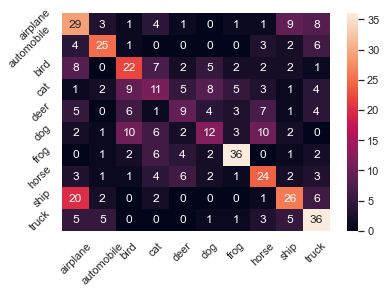

In [31]:
NetworkModel.Evaluate_model(model,images_test.reshape(500,32, 32, 3),testBatch[b'labels'][:500])

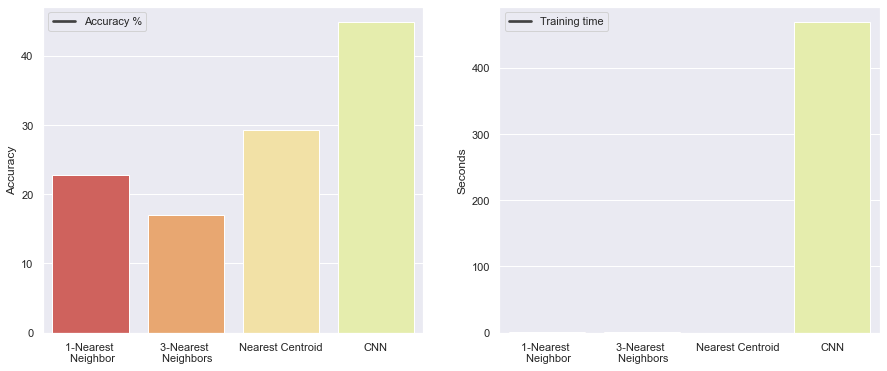

In [32]:
accuracy_and_time = np.vstack((accuracy_and_time,[np.mean(stats.history['val_accuracy'])*100,training_time]))

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,6))

sns.barplot(ax=axes[0],data = {"x" : ["1-Nearest \n Neighbor","3-Nearest \n Neighbors","Nearest Centroid","CNN"] ,
                               "y" : accuracy_and_time[:,0]  } ,x = "x" , y = "y")
axes[0].set_ylabel("Accuracy")
axes[0].legend(["Accuracy %"])


sns.barplot(ax =axes[1] ,data = {"x" : ["1-Nearest \n Neighbor","3-Nearest \n Neighbors","Nearest Centroid","CNN"] ,
                                 "y" : accuracy_and_time[:,1] } ,x = "x" , y = "y")
axes[1].set_ylabel("Seconds")
axes[1].legend(["Training time"])

plt.show()